## Real Estate Market Analysis And Prediction — SQL & Python Project

### Objective: Why this analysis?

In today’s volatile real estate market, understanding the factors that influence house pricing is crucial for both investors and homebuyers. This project dives deep into a **USA real estate dataset** using SQL for querying and Python for analysis and visualization.

Our goal was to:

- Uncover the **key drivers of house prices**.
- Analyze **market trends** over the years.
- Discover how **features like location, garage, garden, pool, and build year** impact pricing.
- Predict **which homes may increase in value in the future** based on scoring.
- Visualize the data in ways that help stakeholders make informed decisions.

---

In [1]:
# Import Libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
df = pd.read_csv('/kaggle/input/housing-prices-regression/real_estate_dataset.csv')

# Create SQLite Memory DB
conn = sqlite3.connect(':memory:')
df.to_sql('housing', conn, index=False, if_exists='replace')


500

In [2]:
df.isnull().sum()


ID                    0
Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64

In [3]:
df.dtypes


ID                      int64
Square_Feet           float64
Num_Bedrooms            int64
Num_Bathrooms           int64
Num_Floors              int64
Year_Built              int64
Has_Garden              int64
Has_Pool                int64
Garage_Size             int64
Location_Score        float64
Distance_to_Center    float64
Price                 float64
dtype: object

In [4]:
df.duplicated().sum()


0

In [5]:
# Check for missing values
df.isnull().sum()

# Optional: Drop rows with missing values or fill
df = df.dropna()

# Create SQLite connection
conn = sqlite3.connect('housing.db')

# Save DataFrame to SQL
df.to_sql('housing', conn, index=False, if_exists='replace')

# Test query
pd.read_sql_query("SELECT * FROM housing LIMIT 5", conn)


,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.655996
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523


#  1. Top 10 Most Expensive Houses

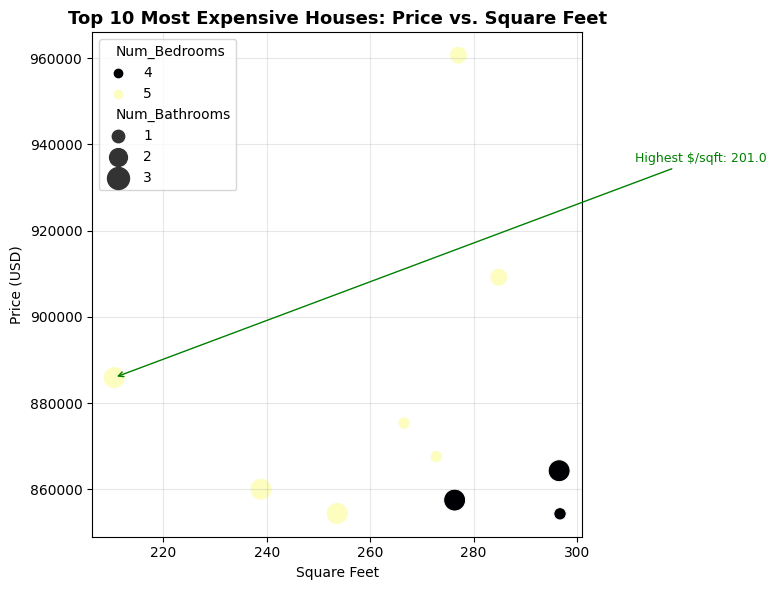

In [6]:
# SQL Query
query1 = """
SELECT ID, Square_Feet, Num_Bedrooms, Num_Bathrooms, Price
FROM housing
ORDER BY Price DESC
LIMIT 10;
"""
top10 = pd.read_sql_query(query1, conn)

# Step 1: Add Price_per_Sqft column
top10['Price_per_Sqft'] = top10['Price'] / top10['Square_Feet']

# Step 2: Identify the house with highest $/sqft
highlight = top10.loc[top10['Price_per_Sqft'].idxmax()]

# Step 3: Visualization
plt.figure(figsize=(8,6))
scatter = sns.scatterplot(
    data=top10,
    x='Square_Feet',
    y='Price',
    hue='Num_Bedrooms',
    size='Num_Bathrooms',
    palette='magma',
    sizes=(80, 250),
    legend='full'
)

# Annotate the standout point
plt.annotate(
    f" Highest $/sqft: {highlight['ID']}",
    xy=(highlight['Square_Feet'], highlight['Price']),
    xytext=(highlight['Square_Feet'] + 100, highlight['Price'] + 50000),
    arrowprops=dict(arrowstyle="->", color='green'),
    fontsize=9, color='green'
)

plt.title("Top 10 Most Expensive Houses: Price vs. Square Feet", fontsize=13, weight='bold')
plt.xlabel("Square Feet")
plt.ylabel("Price (USD)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### We began by identifying the 10 most expensive properties based on their sale prices. Interestingly, when we calculated **Price per Square Foot**, we found one particular house stood out — **very small in size but highly priced per unit area**, likely due to prime location or luxury features.

>  *Insight*: Price ≠ size. **Location and features drive price per square foot.**

---

# 2. Avg. Price by Number of Bedrooms

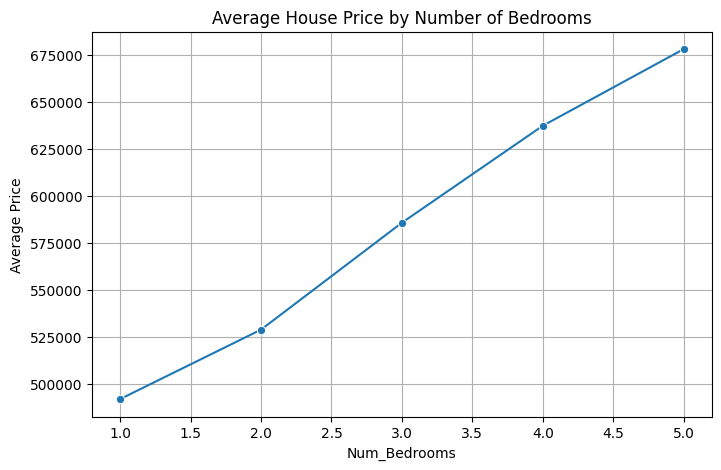

In [7]:
query2 = """
SELECT Num_Bedrooms, AVG(Price) as Avg_Price
FROM housing
GROUP BY Num_Bedrooms
ORDER BY Num_Bedrooms;
"""
bedroom_price = pd.read_sql_query(query2, conn)

# Visualization
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(8,5))
sns.lineplot(data=bedroom_price, x='Num_Bedrooms', y='Avg_Price', marker='o')
plt.title("Average House Price by Number of Bedrooms")
plt.ylabel("Average Price")
plt.grid(True)
plt.show()


#### Price increases with bedroom count, but not linearly. At a certain point, more bedrooms don't significantly add value.

>  *Insight*: There's a **sweet spot** in bedroom count where value peaks.

---

# 3. Price Trend Over Construction Year

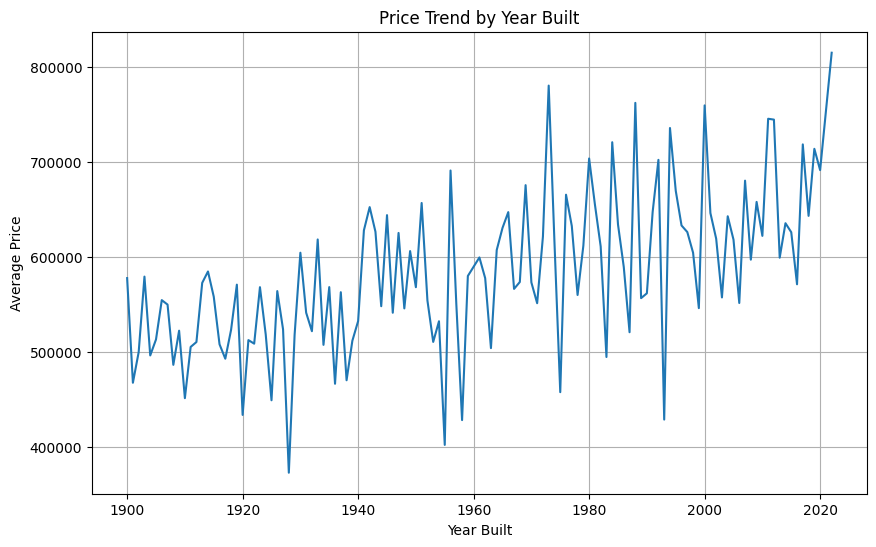

In [8]:
query3 = """
SELECT Year_Built, AVG(Price) as Avg_Price
FROM housing
GROUP BY Year_Built
ORDER BY Year_Built;
"""
yearly_price = pd.read_sql_query(query3, conn)

# Visualization
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(10,6))
sns.lineplot(data=yearly_price, x='Year_Built', y='Avg_Price')
plt.title("Price Trend by Year Built")
plt.xlabel("Year Built")
plt.ylabel("Average Price")
plt.grid(True)
plt.show()


#### We visualized how build year influences price. New homes post-2000 show higher average prices, but some pre-1950 homes are expensive too — likely due to **location or architectural value**.

>  *Insight*: **Old ≠ cheap**. Vintage homes in good locations retain high value.

---

# 4. Distance to Center vs Price

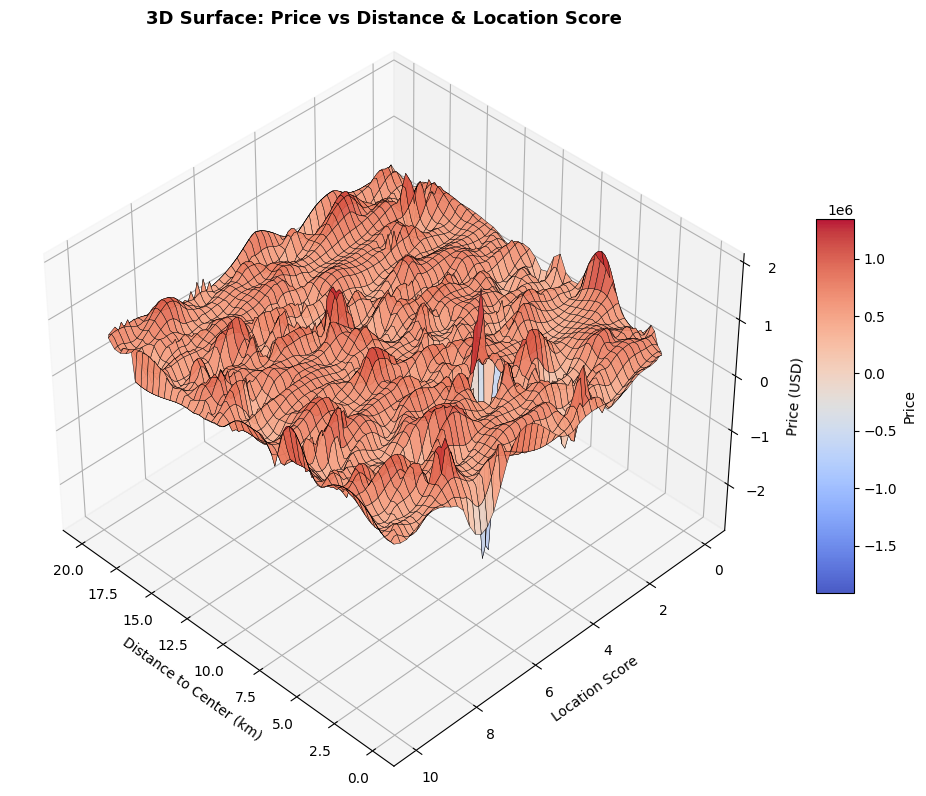

In [9]:
# Step 1: SQL Query
query = """
SELECT ID, Distance_to_Center, Location_Score, Price
FROM housing
WHERE Distance_to_Center IS NOT NULL AND Location_Score IS NOT NULL AND Price IS NOT NULL
"""
df = pd.read_sql_query(query, conn)

# Step 2: Prepare Input Data
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define axes
x = df['Distance_to_Center']
y = df['Location_Score']
z = df['Price']

# Optional: use log scale for better contrast
# z = np.log1p(z)

# Step 3: Create Interpolated Grid (higher resolution = clearer surface)
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

# Step 4: Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(
    X, Y, Z,
    cmap='coolwarm',
    edgecolor='k',
    linewidth=0.3,
    alpha=0.92,
    antialiased=True
)

# Set labels & view angle
ax.set_xlabel('Distance to Center (km)', fontsize=10)
ax.set_ylabel('Location Score', fontsize=10)
ax.set_zlabel('Price (USD)', fontsize=10)
ax.set_title('3D Surface: Price vs Distance & Location Score', fontsize=13, weight='bold')

# Adjust viewpoint to enhance elevation clarity
ax.view_init(elev=40, azim=135)

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Price')

plt.tight_layout()
plt.show()


#### Using 3D plotting, we explored how **distance to city center and location score** together affect prices. While distance often lowers value, a high **location score can counterbalance it**.

>  *Insight*: **Far but fabulous** locations can still demand premium pricing.

---

# 5. Average Price by Garage Size

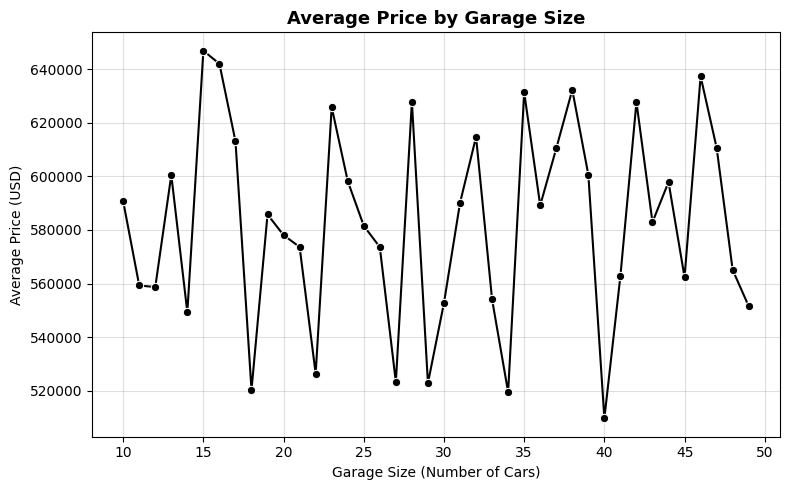

In [10]:
query5 = """
SELECT Garage_Size, AVG(Price) as Avg_Price
FROM housing
GROUP BY Garage_Size
ORDER BY Garage_Size;
"""
garage_price = pd.read_sql_query(query5, conn)

# Visualization
plt.figure(figsize=(8,5))
sns.lineplot(data=garage_price, x='Garage_Size', y='Avg_Price', marker='o', color='black')
plt.title("Average Price by Garage Size", fontsize=13, weight='bold')
plt.xlabel("Garage Size (Number of Cars)")
plt.ylabel("Average Price (USD)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()




#### We found homes with bigger garages tend to have higher average prices and price per square foot.

>  *Insight*: **Garage size** is a strong predictor of house value.

---

#  6. Pool vs No Pool — Average Price

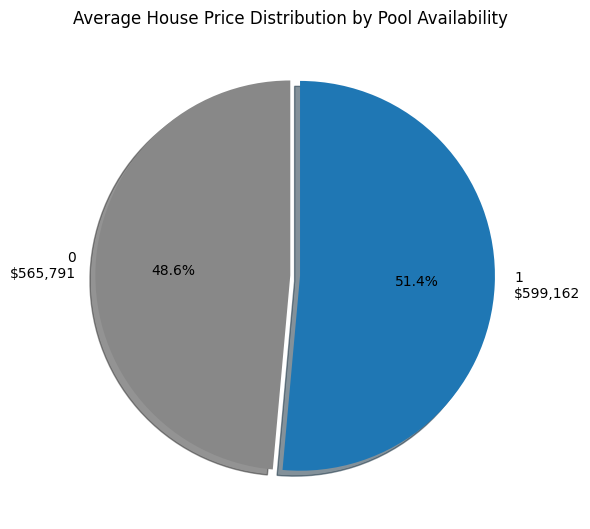

In [11]:
# SQL Query to fetch average price by pool availability
query = """
SELECT Has_Pool, AVG(Price) as Avg_Price
FROM housing
GROUP BY Has_Pool;
"""
pool_price = pd.read_sql_query(query, conn)

# Visualization
# Data
# Data
labels = pool_price['Has_Pool']
values = pool_price['Avg_Price']

# Custom Labels: Pool Type + Avg Price
custom_labels = [
    f"{label}\n${price:,.0f}" for label, price in zip(labels, values)
]

# Colors
colors = ['#888888', '#1f77b4']  # No Pool, Has Pool

# Plot
plt.figure(figsize=(6,6))
plt.pie(
    values,
    labels=custom_labels,
    autopct='%1.1f%%',
    colors=colors,
    explode=[0, 0.05],
    startangle=90,
    shadow=True
)
plt.title('Average House Price Distribution by Pool Availability')
plt.tight_layout()
plt.show()


#### Homes with pools have much higher average prices. While fewer homes have pools, they represent a **larger share of total market value**.

>  *Insight*: A pool significantly boosts home valuation.

---

# 7. Correlation Heatmap

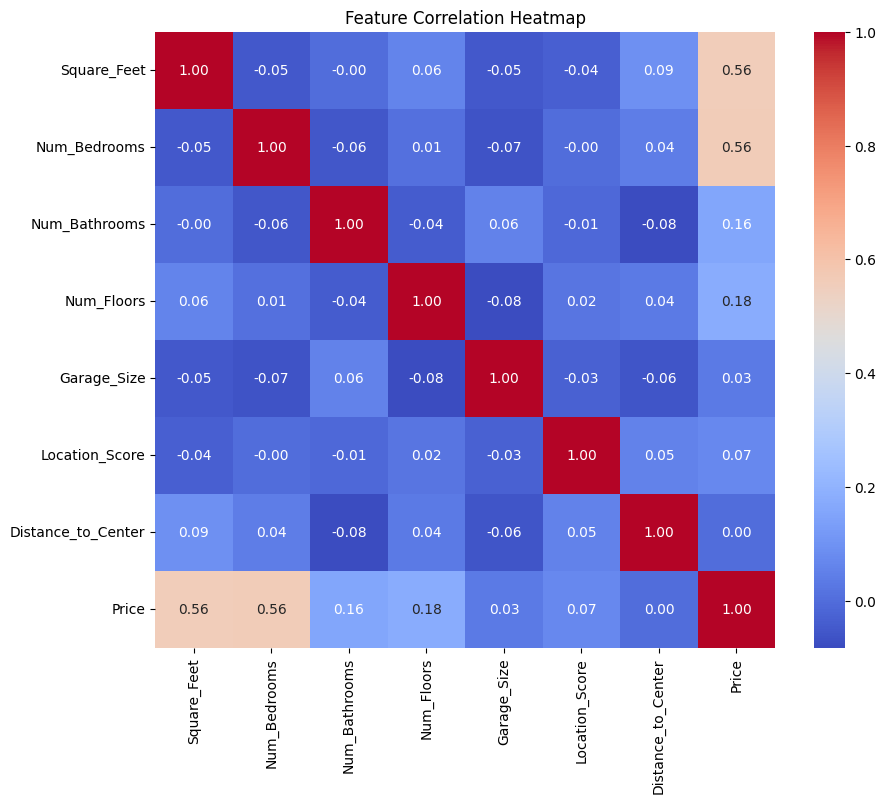

In [12]:
query = """
SELECT Square_Feet, Num_Bedrooms, Num_Bathrooms, Num_Floors,
       Garage_Size, Location_Score, Distance_to_Center, Price
FROM housing;
"""
df = pd.read_sql_query(query, conn)

# Visualization
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


#### Through a heatmap, we found strong correlations between **Price and Square Feet and the Number of Bedrooms**, while features like number of floors or distance had a weaker impact.

>  *Insight*: **Square Feet and the Number of Bedrooms** are key drivers of price.

---

# 8. Price Distribution

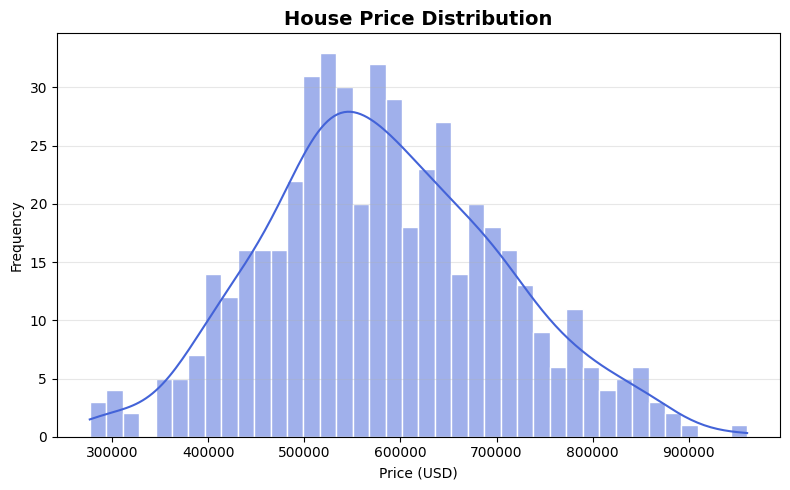

In [13]:
# Step 1: SQL query to fetch house price data
query = """
SELECT Price
FROM housing
WHERE Price IS NOT NULL;
"""
df = pd.read_sql_query(query, conn)

# Visualization
plt.figure(figsize=(8,5))
sns.histplot(
    df['Price'],
    bins=40,
    kde=True,
    color='#4363d8',          # Dark blue shade
    edgecolor='white',
    linewidth=1
)

plt.title("House Price Distribution", fontsize=14, weight='bold')
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


#### A right-skewed histogram revealed most homes are under \$600K, but luxury homes push the upper boundary.

>  *Insight*: Most homes are affordable, but **luxury skews the market.**

---

# 9. Top 10 Highest Location Scores

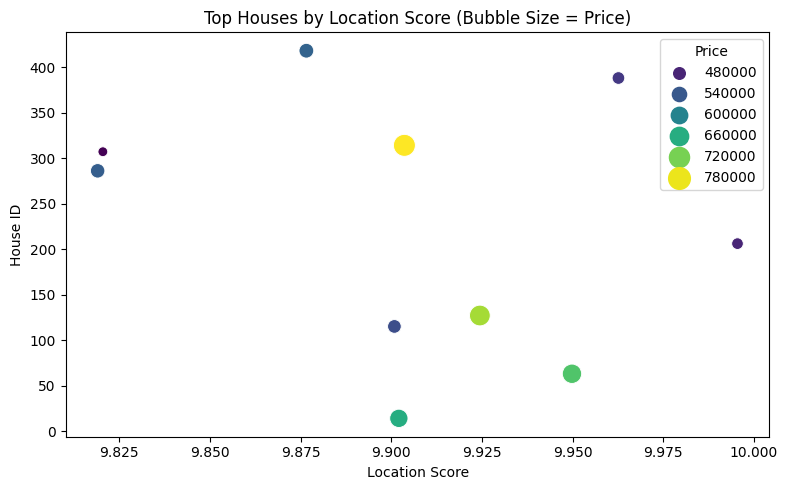

In [14]:
query9 = """
SELECT ID, Location_Score, Price
FROM housing
ORDER BY Location_Score DESC
LIMIT 10;
"""
top_loc = pd.read_sql_query(query9, conn)

# Visualization
plt.figure(figsize=(8,5))
scatter = sns.scatterplot(
    data=top_loc,
    x='Location_Score',
    y='ID',
    size='Price',
    hue='Price',
    palette='viridis',
    legend='brief',
    sizes=(50, 250)
)
plt.title("Top Houses by Location Score (Bubble Size = Price)")
plt.xlabel("Location Score")
plt.ylabel("House ID")
plt.tight_layout()
plt.show()




#### We ranked homes by location quality and noticed even modestly sized houses could fetch high prices due to **excellent neighborhood scores**.

>  *Insight*: **Location is king.** Even average homes rise in value in premium areas.

---

# 10. Houses Built Per Decade

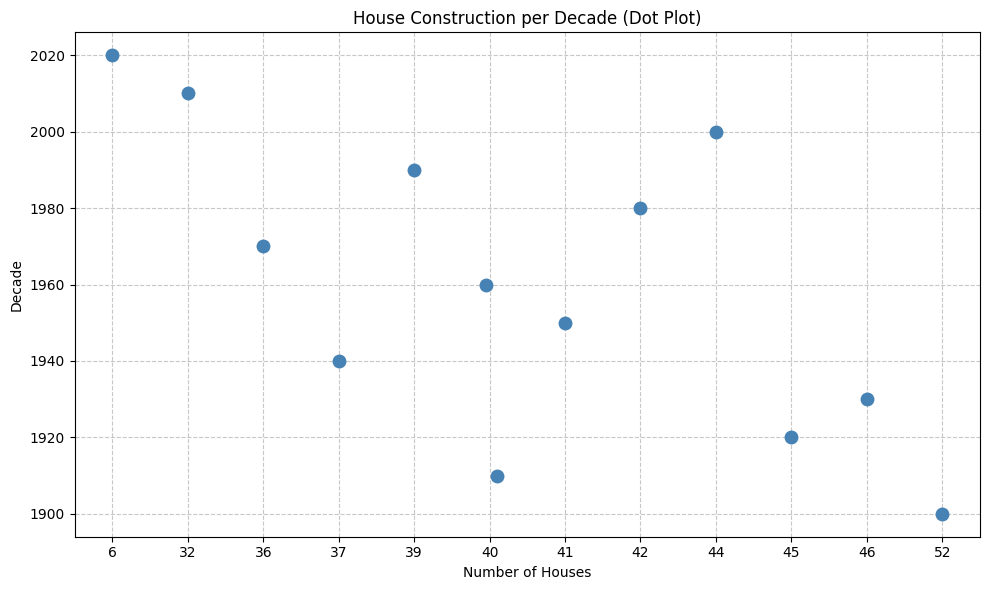

In [15]:
# Step 1: SQL query to get build year data
query = """
SELECT ID, Year_Built
FROM housing
WHERE Year_Built IS NOT NULL
"""
df = pd.read_sql_query(query, conn)

df['Decade'] = (df['Year_Built'] // 10) * 10
decade_count = df['Decade'].value_counts().reset_index()
decade_count.columns = ['Decade', 'House_Count']
decade_count = decade_count.sort_values('Decade')

# Visualization
plt.figure(figsize=(10,6))
sns.stripplot(data=decade_count, x='House_Count', y='Decade', size=10, color='steelblue')
plt.title("House Construction per Decade (Dot Plot)")
plt.xlabel("Number of Houses")
plt.ylabel("Decade")
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


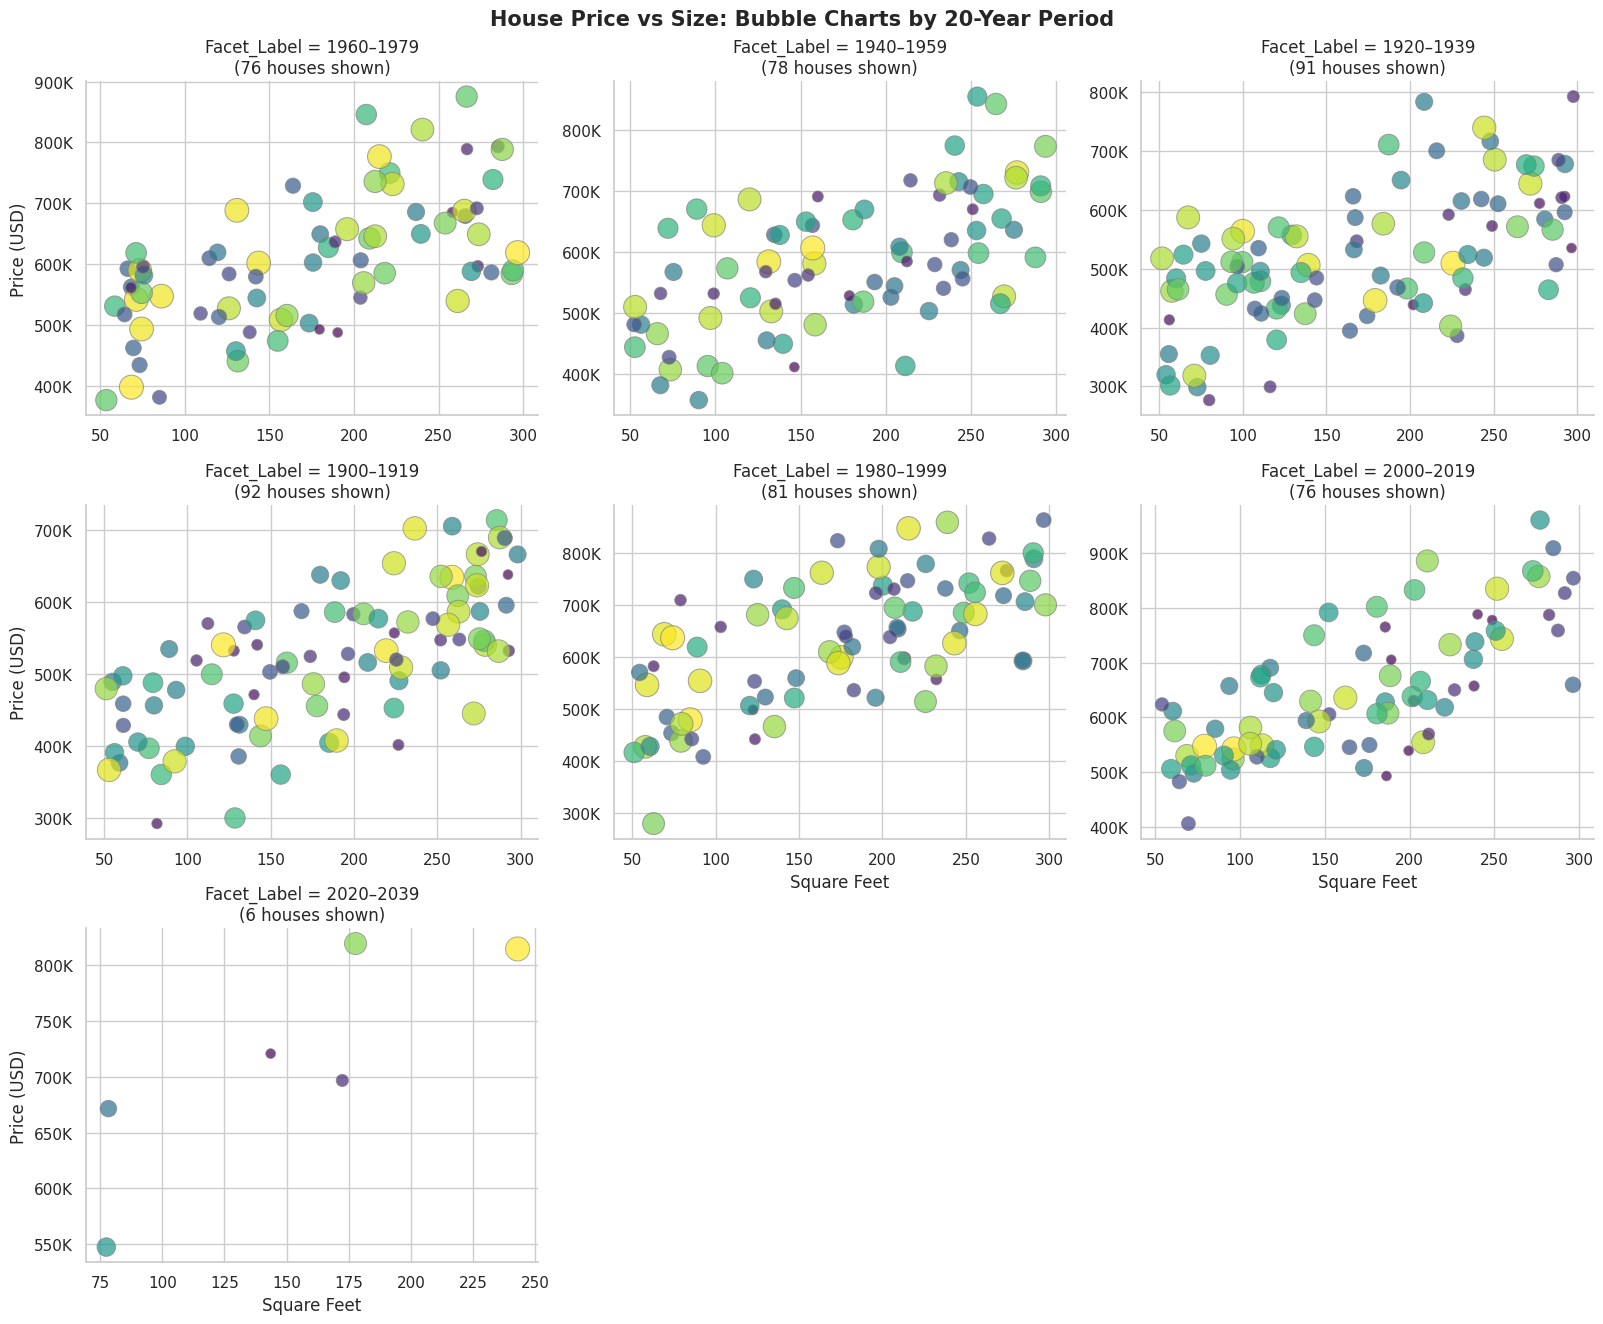

In [16]:
# Step 1: SQL Query
query = """
SELECT ID, Year_Built, Price, Square_Feet, Garage_Size
FROM housing
WHERE Year_Built IS NOT NULL AND Price IS NOT NULL AND Square_Feet IS NOT NULL
"""
df = pd.read_sql_query(query, conn)

# Visualization
# Step 2: Create 20-year group
df['Year_Group'] = (df['Year_Built'] // 20) * 20

# Step 3: Filter groups with more than 5 houses
group_counts = df['Year_Group'].value_counts().sort_index()
valid_groups = group_counts[group_counts > 5].index
df = df[df['Year_Group'].isin(valid_groups)]

# Step 4: Create label for facet titles with range and house count
group_counts_dict = df['Year_Group'].value_counts().to_dict()

def generate_label(year_group):
    start = int(year_group)
    end = start + 19
    count = group_counts_dict.get(year_group, 0)
    return f"{start}–{end}\n({count} houses shown)"

df['Facet_Label'] = df['Year_Group'].apply(generate_label)

# Step 5: Plot with updated facet titles
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from matplotlib.ticker import FuncFormatter

def format_kmb(x, pos):
    if x >= 1_000_000_000:
        return f'{x/1_000_000_000:.1f}B'
    elif x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return int(x)

sns.set(style="whitegrid")
g = sns.FacetGrid(
    df,
    col="Facet_Label",
    col_wrap=3,
    height=4.5,
    aspect=1.2,
    sharex=False,
    sharey=False
)

g.map_dataframe(
    sns.scatterplot,
    x="Square_Feet",
    y="Price",
    size="Garage_Size",
    hue="Garage_Size",
    palette='viridis',
    sizes=(50, 300),
    alpha=0.7,
    edgecolor='gray',
    legend=False
)

g.set_axis_labels("Square Feet", "Price (USD)")
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(FuncFormatter(format_kmb))

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("House Price vs Size: Bubble Charts by 20-Year Period", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()


#### Most homes in the dataset were built between **1950–2010**, with peaks during the 80s and 90s — possibly reflecting suburban expansion.

>  *Insight*: The 1980–1999 construction boom dominates the market.

---

# 11. Which houses will increase in price in the future?

Top 20 Properties with Highest Growth Potential:
     ID          Price  Price_per_Sqft  Location_Score
0    63  695024.310705     2702.435965        9.949814
1   127  743412.143889     2921.026959        9.924423
2   314  789822.931415     2717.323385        9.903618
3   115  527470.102497     2531.642548        9.900864
4   307  446084.368989     2491.046501        9.820495
5    28  528557.486049     2960.134419        9.816533
6   323  747398.279784     3475.473420        9.789575
7   229  635970.991647     2329.464760        9.724200
8   271  635900.840222     2520.013126        9.615133
9    94  488035.884886     2564.300554        9.601678
10  116  654928.118359     2444.991909        9.548470
11   71  627395.372381     2581.223956        9.530200
12   85  458704.412271     3590.765416        9.528968
13  273  789119.858058     2958.074516        9.524671
14  222  630036.340521     3280.121231        9.492086
15   49  519049.392946     2780.459342        9.490712
16   34  506721.

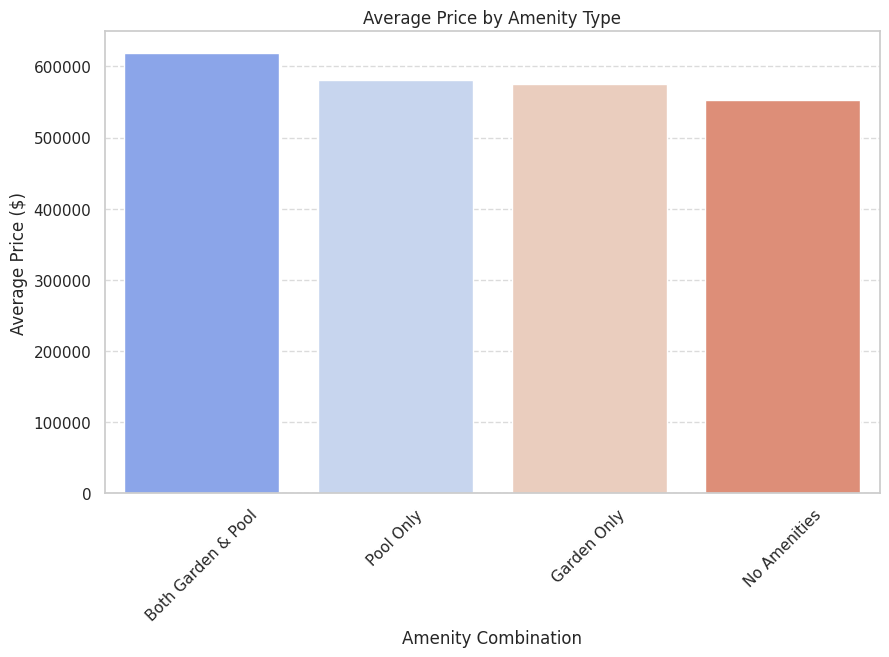

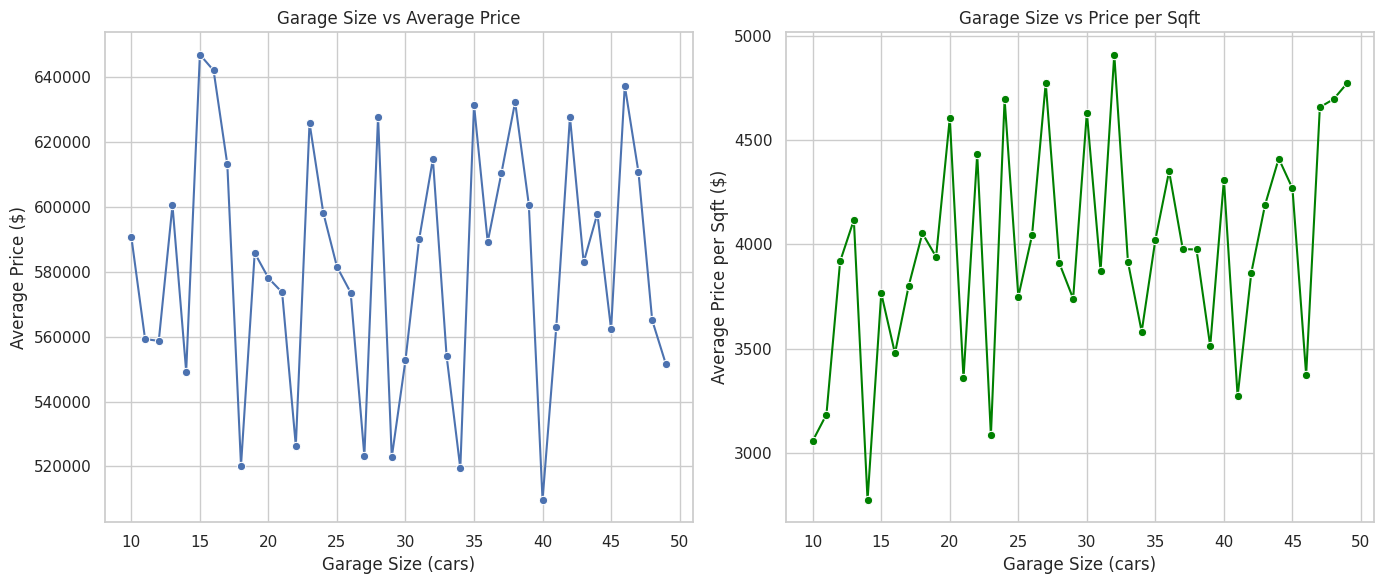

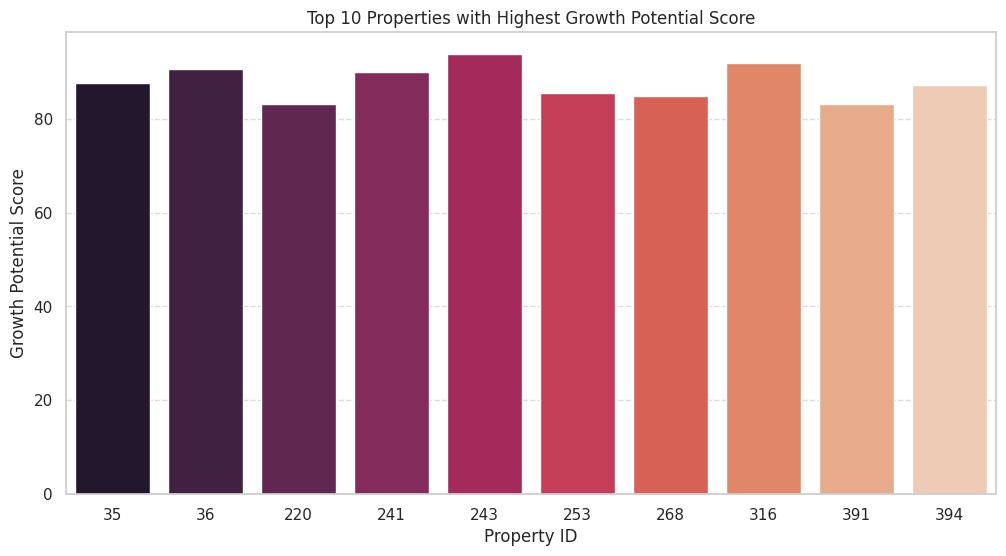


Top 10 Properties with Highest Growth Potential:
    ID          Price  Price_per_Sqft  Location_Score  Growth_Score
0  243  540311.731990     1938.573827        6.651462     93.702868
1  316  452538.093270     2020.317506        9.412724     91.768277
2   36  504981.603574     2003.105639        7.249812     90.632462
3  241  566252.777332     1986.052927        1.421704     89.926599
4   35  595676.979311     2044.133869        3.373401     87.658449
5  394  518571.773137     2124.395288        6.539941     87.222944
6  253  586689.041504     2232.588996        3.872373     85.357025
7  268  509193.376878     2256.852551        3.088344     84.838159
8  220  608932.195928     2321.458671        4.818675     83.118692
9  391  701186.060496     2355.927869        6.706755     83.114090


In [17]:
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Create database connection
conn = sqlite3.connect('housing.db')

# Step 1: Identify Under-Valued Properties
query1 = """
SELECT 
    ID, 
    Price, 
    Square_Feet,
    Price/Square_Feet as Price_per_Sqft,
    Location_Score,
    Num_Bedrooms,
    Num_Bathrooms,
    Has_Garden,
    Has_Pool,
    Garage_Size,
    Year_Built
FROM housing
WHERE 
    (Price/Square_Feet) < (SELECT AVG(Price/Square_Feet) FROM housing WHERE Square_Feet > 0 AND Price > 0)
    AND Location_Score > (SELECT AVG(Location_Score) FROM housing)
    AND Square_Feet > 0 AND Price > 0
ORDER BY Location_Score DESC
LIMIT 20
"""

potential_growth = pd.read_sql_query(query1, conn)
potential_growth.replace([np.inf, -np.inf], np.nan, inplace=True)

# Visualization 1
print("Top 20 Properties with Highest Growth Potential:")
print(potential_growth[['ID', 'Price', 'Price_per_Sqft', 'Location_Score']].fillna(0))

# Step 2: Amenities Analysis
query2 = """
SELECT 
    CASE 
        WHEN Has_Garden = 1 AND Has_Pool = 1 THEN 'Both Garden & Pool'
        WHEN Has_Garden = 1 THEN 'Garden Only'
        WHEN Has_Pool = 1 THEN 'Pool Only'
        ELSE 'No Amenities'
    END as Amenity_Type,
    AVG(Price) as Avg_Price,
    COUNT(*) as Property_Count
FROM housing
GROUP BY Amenity_Type
ORDER BY Avg_Price DESC
"""

amenities = pd.read_sql_query(query2, conn)

# Visualization 2
plt.figure(figsize=(10,6))
sns.barplot(data=amenities.fillna(0), x='Amenity_Type', y='Avg_Price', palette='coolwarm')
plt.title("Average Price by Amenity Type")
plt.xlabel("Amenity Combination")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 3: Garage Size Analysis
query3 = """
SELECT 
    Garage_Size,
    AVG(Price) as Avg_Price,
    AVG(Price/Square_Feet) as Avg_Price_per_Sqft
FROM housing
WHERE Garage_Size IS NOT NULL AND Square_Feet > 0 AND Price > 0
GROUP BY Garage_Size
ORDER BY Garage_Size
"""

garage_impact = pd.read_sql_query(query3, conn)
garage_impact.replace([np.inf, -np.inf], np.nan, inplace=True)

# Visualization 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
sns.lineplot(data=garage_impact.fillna(0), x='Garage_Size', y='Avg_Price', marker='o', ax=ax1)
ax1.set_title("Garage Size vs Average Price")
ax1.set_xlabel("Garage Size (cars)")
ax1.set_ylabel("Average Price ($)")
ax1.grid(True)

sns.lineplot(data=garage_impact.fillna(0), x='Garage_Size', y='Avg_Price_per_Sqft', marker='o', color='green', ax=ax2)
ax2.set_title("Garage Size vs Price per Sqft")
ax2.set_xlabel("Garage Size (cars)")
ax2.set_ylabel("Average Price per Sqft ($)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Step 4: Growth Score Calculation (Fixed Version)
query4 = """
WITH avg_values AS (
    SELECT AVG(Price/Square_Feet) as avg_price_sqft FROM housing WHERE Square_Feet > 0 AND Price > 0
)
SELECT 
    h.ID,
    h.Price,
    h.Square_Feet,
    h.Price/h.Square_Feet as Price_per_Sqft,
    h.Location_Score,
    h.Num_Bedrooms,
    h.Num_Bathrooms,
    h.Has_Garden,
    h.Has_Pool,
    h.Garage_Size,
    h.Year_Built,
    -- Revised Growth Score Calculation (All positive components)
    (h.Location_Score * 0.4) + 
    (CASE WHEN h.Has_Garden = 1 THEN 20 ELSE 0 END) +
    (CASE WHEN h.Has_Pool = 1 THEN 15 ELSE 0 END) +
    (COALESCE(h.Garage_Size, 0) * 0.1) +
    (1 - (h.Price/h.Square_Feet)/av.avg_price_sqft) * 100 as Growth_Score
FROM housing h, avg_values av
WHERE h.Square_Feet > 0 AND h.Price > 0
ORDER BY Growth_Score DESC
LIMIT 10
"""

growth_potential = pd.read_sql_query(query4, conn)
growth_potential.replace([np.inf, -np.inf], np.nan, inplace=True)

# Visualization 4
plt.figure(figsize=(12,6))
sns.barplot(data=growth_potential.fillna(0), x='ID', y='Growth_Score', palette='rocket')
plt.title("Top 10 Properties with Highest Growth Potential Score")
plt.xlabel("Property ID")
plt.ylabel("Growth Potential Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display results
print("\nTop 10 Properties with Highest Growth Potential:")
print(growth_potential[['ID', 'Price', 'Price_per_Sqft', 'Location_Score', 'Growth_Score']].fillna(0))

# Close database connection
conn.close()

### To identify undervalued properties with strong future appreciation potential, we created a **custom "Growth Score"** based on the following:

-  **Above-average Location Score**
-  Presence of **Garden, Pool, or Large Garage**
-  **Low Price per Square Foot** (undervalued relative to market)
-  **Weighted Scoring Formula** combining location, amenities, and cost-efficiency

We found 20 properties with **excellent location scores** and **below-average price per square foot** — a prime combination for future growth.

Then, we developed a **Growth Potential Score** using a formula that combines:

- (Location_Score * 0.4)
- (20 if Has_Garden)
- (15 if Has_Pool)
- (Garage_Size * 0.1)
- (relative cost per square foot)

**Top 10 Houses** were ranked by this score, visualized using a bar plot.

>  *Insight*: Properties with good amenities, excellent location, and undervalued pricing are most likely to **increase in future market value**. This makes them ideal picks for investors and buyers focused on ROI.

---

##  Tools Used

- **SQL (SQLite)** – For querying structured data efficiently
- **Pandas & NumPy** – Data manipulation and transformation
- **Matplotlib & Seaborn** – Interactive visualizations and analysis plots

---

##  Final Thoughts

This project helped us uncover deep insights into how **home features, location, pricing metrics, and time** influence the value of real estate properties.

By combining **SQL querying**, **Python analysis**, and **strategic scoring models**, we could even forecast **which homes are likely to grow in price** — offering value to **investors, analysts, and homebuyers alike.**

>  **Takeaway**: The real value of a home lies in a combination of **location, amenities, size, and intelligent pricing — not just surface numbers.**

---

## Let's Collaborate or Discuss!

> Have questions, suggestions, or a different perspective?  
> Feel free to share your thoughts — I’m always open to learning and improving together!

